In [40]:
import pandas as pd

# To Visualize Data
import matplotlib.pyplot as plt
import seaborn as sns

# To Train our data
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# To evaluate end result we have
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score

import sys
import warnings

warnings.filterwarnings('ignore')

In [2]:
sys.path.insert(1, "../scripts")
from ml_processors import ML_Processor as MLP

mlp = MLP()

In [51]:
ml_data =  pd.read_csv('../data/facebook_data.csv')

In [52]:
columns_to_be_dropped = ['no','SAID_YES']
ml_data_clean = ml_data.drop(columns_to_be_dropped,axis=1)
ml_data_clean.head(2)

,auction_id,experiment,date,hour,device_make,browser,yes
0,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,Facebook,1
1,023458f7-122d-475f-9525-1b9a3cc7a033,control,2020-07-03,15,MRD-LX1,Facebook,0


In [53]:

cat, num = mlp.sep_cat_num(ml_data_clean)
print("Numerical Columns:", cat)
print("****************")
print("Categorical Columns:", num)

Numerical Columns: ['auction_id', 'experiment', 'date', 'device_make', 'browser']
****************
Categorical Columns: ['hour', 'yes']


In [54]:
ml_data_clean[cat].describe()

,auction_id,experiment,date,device_make,browser
count,156,156,156,156,156
unique,156,2,8,63,1
top,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-03,Samsung SM-G960F,Facebook
freq,1,112,47,16,156


In [55]:
pipe_1 = Pipeline(
    steps=[
        ("label categories", FunctionTransformer(mlp.cat_labeler, kw_args={"cat_cols": cat})),
        ("scale data", FunctionTransformer(mlp.scaler)),
        ("separate target and features", FunctionTransformer(mlp.target_feature, kw_args={"f_r": [0, 6], "t":-1})),
        ("divide dataset", FunctionTransformer(mlp.set_splitter, kw_args={"test": 0.1, "val":0.2, "rand_state":8})),      
        ])
sets = pipe_1.fit_transform(ml_data_clean)

cat_labeler output...

   auction_id  experiment  date  hour  device_make  browser  yes
0           0           0     5     4           23        0    1
1           1           0     0    15           12        0    0


scaler output... 

   auction_id  experiment      date      hour  device_make  browser  yes
0    0.000000         0.0  0.714286  0.173913     0.370968      0.0  1.0
1    0.006452         0.0  0.000000  0.652174     0.193548      0.0  0.0


target_features output... 

features size: (156, 6)


set_splitter output... 

X_train shape: (114, 6)
y_train shape: (114,)
x_test shape: (16, 6)
y_test shape: (16,)
X_val shape: (26, 6)
y_val shape: (26,)


predicted:  [0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Actual: [1. 0. 0. 0. 1. 1. 1. 0. 1. 0.]
0.5625


Text(0, 0.5, 'Feature Importance Score')

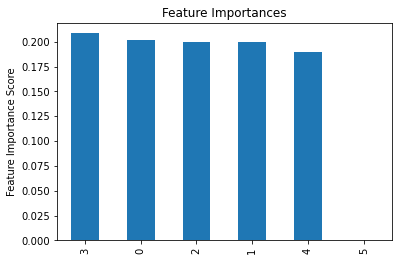

In [58]:
# Define XGBoost Model
model = XGBClassifier(
 learning_rate =0.08,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 eval_metric='rmse',
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)
 
xgb_param = model.get_xgb_params()
xgtrain = xgb.DMatrix(sets[0], label=sets[1])
cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5,
    metrics='auc', early_stopping_rounds=50)
model.set_params(n_estimators=cvresult.shape[0])
# We fit our model with our train data
model.fit(
    sets[0], sets[1],
    eval_set=[(sets[4], sets[5])],
    verbose=False
 )
# Then predict results from X_test data
pred_xgb = model.predict(sets[2])

print("predicted: ", pred_xgb[0:10])
# See First 10 Predictions and They Actual Values
# print("Predicted:", pred_xgb[0:10])
print("Actual:", sets[3][0:10])

accuracy = accuracy_score(pred_xgb, sets[3])
print(accuracy)

feat_imp = pd.Series(model.feature_importances_).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [33]:
pipe_2 =Pipeline([('scalar1',StandardScaler()),('lr_classifier',
    XGBClassifier(n_estimators=1000, learning_rate=0.001, eval_metric='rmse'))])

In [34]:
pipe_2.fit(sets[0], sets[1])
pipe_2.score(sets[4],sets[5])

0.5663716814159292